# Practice Basic Classification Systems

#### Date: 25/03/2023

#### Author: Elena Aguayo Jara, Yiran Du

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import matplotlib as mpl
from sklearn.metrics import  confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### Dataset Preparation

In [2]:
# Load the datasets
breast_cancer = pd.read_csv('wdbc.csv')
prostate_cancer = pd.read_csv('prostate.csv')

# Separate the target variable from the predictor variables
prostate = prostate_cancer.iloc[:, :-1]

# Scale the predictor variables
prostate_scaled = StandardScaler().fit_transform(prostate)

# Apply PCA to the scaled predictor variables
pca = PCA()
X_prostate_pca = pca.fit_transform(prostate_scaled)

variance_ratio = pca.explained_variance_ratio_
#print (variance_ratio)
accum = 0
for i in range(len(variance_ratio)):
    accum += variance_ratio[i]
    if accum >= 0.99:
        print ("The number of components necessary to retain at least 99% of variance on the features is :", (i+1))
        break 

n_components = 94
pca = PCA(n_components=n_components)
pca.fit(prostate_scaled)
pca_final = pca.transform(prostate_scaled)
print ("Therefore, the original shape of the features is:", prostate_scaled.shape, 
       "and, the final shape of the features after PCA is:", pca_final.shape)

# Prepare all the datasets
X_breast = breast_cancer.iloc[:, 2:]
y_breast = breast_cancer.iloc[:, 1].apply(lambda x: 1 if x == 'M' else 0)

X_prostate = pca_final
y_prostate = prostate_cancer.iloc[:, -1]

# Preprocess the datasets    
def prep_data(X, y, random_state):    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state = random_state)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test


# Define the number of repetitions
n_repeats = 20

# Define lists to store the results
bc_errors = []
pc_errors = []

The number of components necessary to retain at least 99% of variance on the features is : 94
Therefore, the original shape of the features is: (102, 12625) and, the final shape of the features after PCA is: (102, 94)


## The Naive Bayes Classifier

In [3]:
for i in tqdm(range(n_repeats)):
    # Split the datasets
    X_breast_train, X_breast_test, y_breast_train, y_breast_test = prep_data(X_breast, y_breast, random_state = i)
    X_prostate_train, X_prostate_test, y_prostate_train, y_prostate_test = prep_data(X_prostate, y_prostate, random_state = i)
    
    # Tune hyperparameters
    nb = GaussianNB()
    param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
    grid_search = GridSearchCV(nb, param_grid, cv=5)
    grid_search.fit(X_breast_train, y_breast_train)
    best_nb_bc = grid_search.best_estimator_

    grid_search.fit(X_prostate_train, y_prostate_train)
    best_nb_pc = grid_search.best_estimator_

    # Make predictions on the test data and calculate prediction errors
    bc_preds_naive = best_nb_bc.predict(X_breast_test)
    pc_preds_naive = best_nb_pc.predict(X_prostate_test)
    bc_error = 1 - accuracy_score(y_breast_test, bc_preds_naive)
    pc_error = 1 - accuracy_score(y_prostate_test, pc_preds_naive)
    bc_errors.append(bc_error)
    pc_errors.append(pc_error)

# Report average error results
print('Naive Bayes: Breast Cancer prediction error:', np.mean(bc_errors))
print('Naive Bayes: Prostate Cancer prediction error:', np.mean(pc_errors))

100%|██████████| 20/20 [00:01<00:00, 10.96it/s]

Naive Bayes: Breast Cancer prediction error: 0.06631578947368419
Naive Bayes: Prostate Cancer prediction error: 0.3808823529411764


The prediction error in prostate cancer es very low

Then, we compute the matrix confusion of breast cancer dataset.

In [57]:
conf = confusion_matrix(y_breast_test, bc_preds_naive)

TN = conf[0][0]
TP = conf[1][1]
FP = conf[0][1]
FN = conf[1][0]

print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[117   2]
 [  7  64]]
Predicion accuracy is: 0.952632
True postive rate is: 0.901408
True negative rate is: 0.983193



Matrix confusion of prostate cancer dataset

In [58]:
conf = confusion_matrix(y_prostate_test, pc_preds_naive)

TN = conf[0][0]
TP = conf[1][1]
FP = conf[0][1]
FN = conf[1][0]

print(conf)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[16  2]
 [ 6 10]]
Predicion accuracy is: 0.764706
True postive rate is: 0.625000
True negative rate is: 0.888889



We can see that the accuracy is quite low as well as the true positive rate. This is reflected in the ranking shown in the plot below.

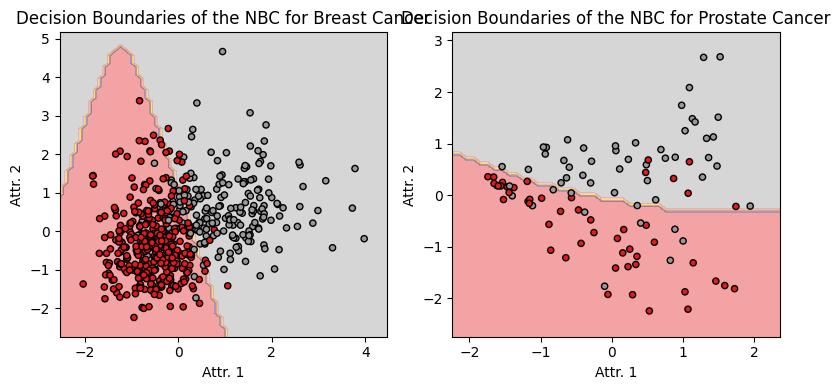

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

# Plot decision boundaries for Breast Cancer dataset
X_scaled = StandardScaler().fit_transform(X_breast)
nb = GaussianNB().fit(X_scaled[:,:2], y_breast)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
np.arange(y_min, y_max, 0.1))

Z = nb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_breast, s=20, edgecolor='k',
cmap=plt.cm.Set1)
axs[0].set_title('Decision Boundaries of the NBC for Breast Cancer')
axs[0].set_xlabel('Attr. 1')
axs[0].set_ylabel('Attr. 2')

# Plot decision boundaries for Prostate Cancer dataset
X_scaled = StandardScaler().fit_transform(X_prostate)
nb = GaussianNB().fit(X_scaled[:,:2], y_prostate)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
np.arange(y_min, y_max, 0.1))

Z = nb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_prostate, s=20, edgecolor='k',
cmap=plt.cm.Set1)
axs[1].set_title('Decision Boundaries of the NBC for Prostate Cancer')
axs[1].set_xlabel('Attr. 1')
axs[1].set_ylabel('Attr. 2')

plt.tight_layout()
plt.show()


As we can see, the Naive Bayes classifiers separates breast cancer data better than prostate cancer data, this is consistent with the predicted error being higher in breast cancer data.

## LDA

In [5]:
for i in tqdm(range(n_repeats)):
    # Split the datasets
    X_breast_train, X_breast_test, y_breast_train, y_breast_test = prep_data(X_breast, y_breast, random_state = i)
    X_prostate_train, X_prostate_test, y_prostate_train, y_prostate_test = prep_data(X_prostate, y_prostate, random_state = i)
    
    # Tune hyperparameters
    lda = LDA()
    param_grid = {'shrinkage': np.arange(0, 1.1, 0.1), 'solver': ['lsqr', 'eigen']}
    grid_search = GridSearchCV(lda, param_grid, cv=5)
    grid_search.fit(X_breast_train, y_breast_train)
    best_lda_bc = grid_search.best_estimator_

    grid_search.fit(X_prostate_train, y_prostate_train)
    best_lda_pc = grid_search.best_estimator_

    # Make predictions on the test data and Calculate the prediction errors and store them
    bc_pred = best_lda_bc.predict(X_breast_test)
    pc_pred = best_lda_pc.predict(X_prostate_test)

    bc_error = 1 - accuracy_score(y_breast_test, bc_pred)
    pc_error = 1 - accuracy_score(y_prostate_test, pc_pred)
    bc_errors.append(bc_error)
    pc_errors.append(pc_error)

# Report average error results
print('LDA: Breast Cancer prediction error:', np.mean(bc_errors))
print('LDA: Prostate Cancer prediction error:', np.mean(pc_errors))

100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

LDA: Breast Cancer prediction error: 0.055131578947368434
LDA: Prostate Cancer prediction error: 0.4080882352941176


The results are better than the Naive Bayes classifier

Then, we compute the confusion matrix on the test set of breast cancer

In [6]:
conf_breast = confusion_matrix(y_breast_test, bc_pred)
TN = conf_breast[0][0]
TP = conf_breast[1][1]
FP = conf_breast[0][1]
FN = conf_breast[1][0]

print(conf_breast)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[119   0]
 [ 12  59]]
Predicion accuracy is: 0.936842
True postive rate is: 0.830986
True negative rate is: 1.000000



The confusion matrix of prostate cancer dataset.

In [7]:
conf_prostate = confusion_matrix(y_prostate_test, pc_pred)
TN = conf_prostate[0][0]
TP = conf_prostate[1][1]
FP = conf_prostate[0][1]
FN = conf_prostate[1][0]

print(conf_prostate)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[ 8 10]
 [ 4 12]]
Predicion accuracy is: 0.588235
True postive rate is: 0.750000
True negative rate is: 0.444444



As we observed, the accuracy is low.

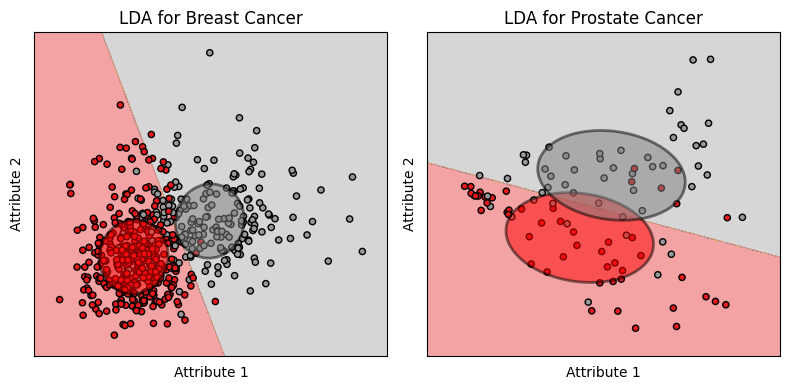

In [8]:
def plot_ellipse(splot, mean, cov, color):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())

f, axs = plt.subplots(1, 2, figsize=(8,4))

# Plot decision boundaries for Breast Cancer dataset using LDA
X_scaled = StandardScaler().fit_transform(X_breast)
lda = LDA(store_covariance=True).fit(X_scaled[:,:2], y_breast)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_breast, s=20, edgecolor='k', cmap=plt.cm.Set1)
axs[0].set_title('LDA for Breast Cancer')
axs[0].set_xlabel('Attribute 1')
axs[0].set_ylabel('Attribute 2')
plot_ellipse(axs[0], lda.means_[0], lda.covariance_, 'red')
plot_ellipse(axs[0], lda.means_[1], lda.covariance_, 'gray')

# Plot decision boundaries for Prostate Cancer dataset using LDA
X_scaled = StandardScaler().fit_transform(X_prostate)
lda = LDA(store_covariance=True).fit(X_scaled[:,:2], y_prostate)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_prostate, s=20, edgecolor='k', cmap=plt.cm.Set1)
axs[1].set_title('LDA for Prostate Cancer')
axs[1].set_xlabel('Attribute 1')
axs[1].set_ylabel('Attribute 2')

plot_ellipse(axs[1], lda.means_[0], lda.covariance_, 'red')
plot_ellipse(axs[1], lda.means_[1], lda.covariance_, 'gray')

plt.tight_layout()
plt.show()

The covariance matrices in LDA are the same. In the case of prostate cancer data, it is not able to separate the two classes well, as we obtained in the confusion matrix, the accuracy was quite low.

## QDA

In [9]:
for i in tqdm(range(n_repeats)):
    # Split the datasets
    X_breast_train, X_breast_test, y_breast_train, y_breast_test = prep_data(X_breast, y_breast, random_state = i)
    X_prostate_train, X_prostate_test, y_prostate_train, y_prostate_test = prep_data(X_prostate, y_prostate, random_state = i)

    # Tune hyperparameters
    qda = QDA()
    param_grid = {'reg_param': np.arange(0, 1.1, 0.1)}
    grid_search = GridSearchCV(qda, param_grid, cv=5)
    grid_search.fit(X_breast_train, y_breast_train)
    best_qda_bc = grid_search.best_estimator_

    grid_search.fit(X_prostate_train, y_prostate_train)
    best_qda_pc = grid_search.best_estimator_

    # Make predictions on the test data
    bc_pred_qda = best_qda_bc.predict(X_breast_test)
    pc_pred_qda = best_qda_pc.predict(X_prostate_test)

    # Calculate prediction errors and store them
    bc_error = 1 - accuracy_score(y_breast_test, bc_pred_qda)
    pc_error = 1 - accuracy_score(y_prostate_test, pc_pred_qda)
    bc_errors.append(bc_error)
    pc_errors.append(pc_error)

# Report average error results
print('QDA: Breast Cancer prediction error:', np.mean(bc_errors))
print('QDA: Prostate Cancer prediction error:', np.mean(pc_errors))

100%|██████████| 20/20 [00:05<00:00,  3.36it/s]

QDA: Breast Cancer prediction error: 0.04877192982456142
QDA: Prostate Cancer prediction error: 0.4421568627450981


In this step, we compute the confusion matrix on the test set of breast cancer data.

In [10]:
from sklearn.metrics import  confusion_matrix

conf_breast = confusion_matrix(y_breast_test, bc_pred_qda)
TN = conf_breast[0][0]
TP = conf_breast[1][1]
FP = conf_breast[0][1]
FN = conf_breast[1][0]

print(conf_breast)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[119   0]
 [  7  64]]
Predicion accuracy is: 0.963158
True postive rate is: 0.901408
True negative rate is: 1.000000



The confusion matrix of prostate cancer test.

In [11]:
conf_prostate = confusion_matrix(y_prostate_test, pc_pred_qda)
TN = conf_prostate[0][0]
TP = conf_prostate[1][1]
FP = conf_prostate[0][1]
FN = conf_prostate[1][0]

print(conf_prostate)
print('Predicion accuracy is: %f' % ((TP + TN) / (TN + TP + FP + FN)))
print('True postive rate is: %f' % (TP / (TP + FN)))
print('True negative rate is: %f\n' % (TN / (TN + FP)))

[[13  5]
 [11  5]]
Predicion accuracy is: 0.529412
True postive rate is: 0.312500
True negative rate is: 0.722222



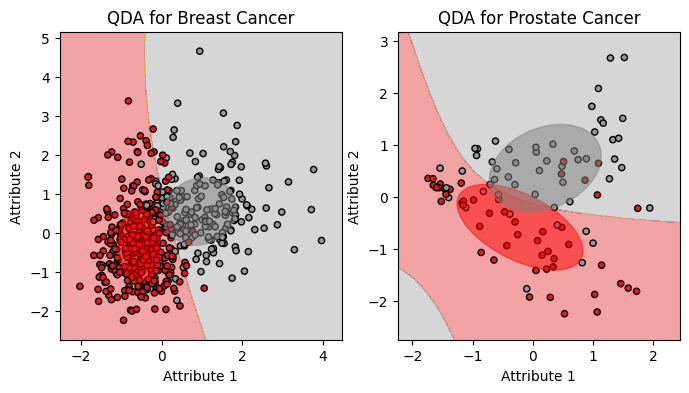

In [12]:
def plot_ellipse(ax, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5, 180 + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)

# Plot decision boundaries for Breast Cancer dataset using QDA
fig, axs = plt.subplots(1, 2, figsize=(8,4))

X_scaled = StandardScaler().fit_transform(X_breast)
qda = QDA(store_covariance=True).fit(X_scaled[:,:2], y_breast)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_breast, s=20, edgecolor='k', cmap=plt.cm.Set1)
axs[0].set_title('QDA for Breast Cancer')
axs[0].set_xlabel('Attribute 1')
axs[0].set_ylabel('Attribute 2')
plot_ellipse(axs[0], qda.means_[0], qda.covariance_[0], 'red')
plot_ellipse(axs[0], qda.means_[1], qda.covariance_[1], 'gray')

# Plot decision boundaries for Prostate Cancer dataset using QDA
X_scaled = StandardScaler().fit_transform(X_prostate)
qda = QDA(store_covariance=True).fit(X_scaled[:,:2], y_prostate)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_prostate, s=20, edgecolor='k', cmap=plt.cm.Set1)
axs[1].set_title('QDA for Prostate Cancer')
axs[1].set_xlabel('Attribute 1')
axs[1].set_ylabel('Attribute 2')
plot_ellipse(axs[1], qda.means_[0], qda.covariance_[0], 'red')
plot_ellipse(axs[1], qda.means_[1], qda.covariance_[1], 'gray')

We can see that the covariance matrices in QDA are different, so the estimated class priors very different. In this case, as well as LDA classifier, QDA can't separate very well the classes of prostatet cancer dataset.

## Nearest Shrunken Centroids Classifier

In [13]:
for i in tqdm(range(n_repeats)):
    # Split the datasets
    X_breast_train, X_breast_test, y_breast_train, y_breast_test = train_test_split(X_breast, y_breast, test_size=1/3, random_state=i)
    X_prostate_train, X_prostate_test, y_prostate_train, y_prostate_test = train_test_split(X_prostate, y_prostate, test_size=1/3, random_state=i)

    # Tune hyperparameters
    nc = NearestCentroid()
    param_grid = {'shrink_threshold': np.arange(0, 1.1, 0.1)}
    grid_search = GridSearchCV(nc, param_grid, cv=5)
    grid_search.fit(X_breast_train, y_breast_train)
    best_shrink_bc = grid_search.best_params_['shrink_threshold']

    grid_search.fit(X_prostate_train, y_prostate_train)
    best_shrink_pc = grid_search.best_params_['shrink_threshold']

    # Train the classifiers with the best hyperparameters
    nc_bc = NearestCentroid(shrink_threshold=best_shrink_bc)
    nc_pc = NearestCentroid(shrink_threshold=best_shrink_pc)
    nc_bc.fit(X_breast_train, y_breast_train)
    nc_pc.fit(X_prostate_train, y_prostate_train)

    # Make predictions on the test data
    y_pred_bc_cent = nc_bc.predict(X_breast_test)
    y_pred_pc_cent = nc_pc.predict(X_prostate_test)

    # Calculate the prediction errors and store them
    bc_errors[i] = 1 - accuracy_score(y_breast_test, y_pred_bc_cent)
    pc_errors[i] = 1 - accuracy_score(y_prostate_test, y_pred_pc_cent)

# Report average error results
print('Nearest Shrunken Centroids: Breast Cancer prediction error:', np.mean(bc_errors))
print('Nearest Shrunken Centroids: Prostate Cancer prediction error:', np.mean(pc_errors))

100%|██████████| 20/20 [00:09<00:00,  2.15it/s]

Nearest Shrunken Centroids: Breast Cancer prediction error: 0.06578947368421054
Nearest Shrunken Centroids: Prostate Cancer prediction error: 0.4323529411764706


Matrix confusion of breast cancer dataset

In [17]:
conf = confusion_matrix(y_breast_test, y_pred_bc_cent)

print(conf)
print('\nPredicion accuracy is: %f' % (np.sum(np.diag(conf)) / np.sum(conf)))

[[119   0]
 [ 24  47]]

Predicion accuracy is: 0.873684
True postive rate is: 0.312500
True negative rate is: 0.722222



Matrix confusión of prostate cancer dataset

In [18]:
conf = confusion_matrix(y_prostate_test, y_pred_pc_cent)

print(conf)
print('\nPredicion accuracy is: %f' % (np.sum(np.diag(conf)) / np.sum(conf)))

[[13  5]
 [ 4 12]]

Predicion accuracy is: 0.735294
True postive rate is: 0.312500
True negative rate is: 0.722222



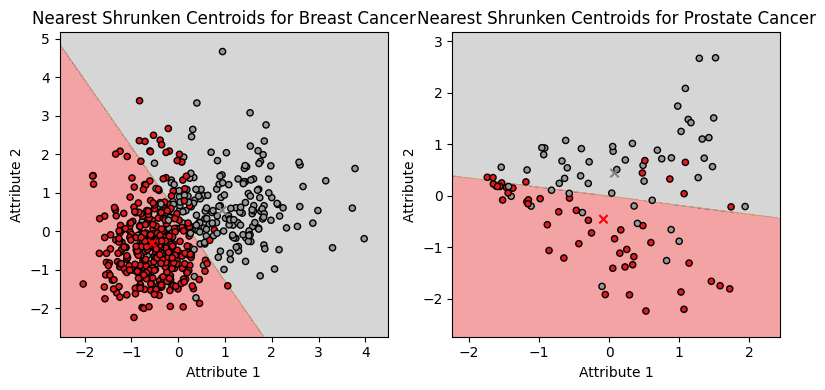

In [16]:
f, axs = plt.subplots(1, 2, figsize=(8,4))

# Plot decision boundaries and centroids for Breast Cancer dataset using Nearest Shrunken Centroids
X_scaled = StandardScaler().fit_transform(X_breast)
nc = NearestCentroid(shrink_threshold=best_shrink_bc)
nc.fit(X_scaled[:,:2], y_breast)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = nc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_breast, s=20, edgecolor='k', cmap=plt.cm.Set1)
axs[0].set_title('Nearest Shrunken Centroids for Breast Cancer')
axs[0].set_xlabel('Attribute 1')
axs[0].set_ylabel('Attribute 2')
axs[0].scatter(nc.centroids_[:, 0], nc.centroids_[:, 1], c=['red', 'gray'], marker='x')

# Plot decision boundaries and centroids for Prostate Cancer dataset using Nearest Shrunken Centroids
X_scaled = StandardScaler().fit_transform(X_prostate)
nc = NearestCentroid(shrink_threshold=best_shrink_pc)
nc.fit(X_scaled[:,:2], y_prostate)
x_min, x_max = X_scaled[:, 0].min() - .5, X_scaled[:, 0].max() + .5
y_min, y_max = X_scaled[:, 1].min() - .5, X_scaled[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

Z = nc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
axs[1].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.Set1)
axs[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_prostate, s=20, edgecolor='k', cmap=plt.cm.Set1)
axs[1].set_title('Nearest Shrunken Centroids for Prostate Cancer')
axs[1].set_xlabel('Attribute 1')
axs[1].set_ylabel('Attribute 2')
axs[1].scatter(nc.centroids_[:, 0], nc.centroids_[:, 1], c=['red', 'gray'], marker='x')

plt.tight_layout()
plt.show()

The performance of each classifier will depend on the  the characteristics of our data. Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) are both parametric classifiers that assume the data is distributed according to multivariate Gaussian distributions. LDA assumes that the covariance matrix is the same for all classes, while QDA assumes that the covariance matrix is different for each class. If the assumption of equal covariance is reasonable, LDA may perform better and  less prone to overfitting than QDA. However, if the data have highly non-linear relationships or if the assumption of equal covariance is not good or we have few data, QDA may perform better.

Naive Bayes is a probabilistic classifier that assumes the features are conditionally independent given the class label. This simplifying assumption makes the model computationally efficient and can work well when the independence assumption is approximately true. In terms of flexibility, The Naive Bayes classifier is often considered more flexible than the other classifiers used in this practical. This is because it makes a simplifying assumption of independence between the features, which reduces the complexity of the model and makes it easier to fit to the data. However, this assumption may not always hold in practice, and in some cases, it may lead to suboptimal performance.

Nearest Shrunken Centroids (NSC) is a variant of linear discriminant analysis that includes regularization. Regularization can help prevent overfitting by shrinking the estimated coefficients towards zero. NSC is particularly useful in high-dimensional data, where overfitting can be a significant problem. So, the methods that are more robust to over-fitting are those that have some form of regularization, which helps to prevent the model from fitting the noise in the data. In this practical, the Nearest Shrunken Centroids (NSC) classifier has a regularization parameter as well as The Linear Discriminant Analysis (LDA) classifier which is the shrinkage parameter that shrinks the estimated covariance matrix towards a diagonal matrix. However, the other classifiers used in this practical, such as the Gaussian Naive Bayes (GNB) and Quadratic Discriminant Analysis (QDA) do not have any explicit regularization, and therefore, may be more prone to over-fitting in some cases.

It is often a good idea to try several different classifiers and compare their performance on a validation set or through cross-validation to determine which one works best for your problem.

In this case, we can see that the best classifier of breast cancer data is the Nearest Shrunken Centroids classifier since its mean error prediction is higher, however, the worst classification method may vary each time. Something similar happens with prostate cancer data, where no one method stands out above the other. It is important to note that the difference in prediction errors between the different methods was relatively small, and therefore, more experiments would be needed to draw more definitive conclusions.